In [ ]:
import time
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import powerlaw as pwl

In [ ]:
# authenticate bigquery API
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

project_id = 'ethereum-<>'
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

Authenticated


# Graph construction

In [ ]:
# get 2015 transaction dataset
# repeated for each year (2015 - 2020)
df = client.query('''
SELECT * 
FROM `ethereum-305608.transactions.transactions_2020`''').to_dataframe()

# construct MultiDiGraph
G = nx.from_pandas_edgelist(df, 'from_address', 'to_address', ["value"], create_using=nx.MultiDiGraph())

In [ ]:
# aggregate multi edges into single directed edge
df_aggregate = client.query('''
SELECT from_address, to_address, sum(value) as total_value
FROM `ethereum-305608.transactions.transactions_2015`
group by from_address, to_address;''').to_dataframe()

# construct DiGraph
G1 = nx.from_pandas_edgelist(df_aggregate, 'from_address', 'to_address', ["total_value"], create_using=nx.DiGraph())

# Basic graph metrics

In [ ]:
# average degree = sum of degree / no. of nodes
total_nodes = G.number_of_nodes()
degrees = G.degree()
avg_deg = sum(deg for n, deg in degrees) / total_nodes
print(avg_deg)

# avg in degree and out degree
in_degrees = G.in_degree()
out_degrees = G.out_degree()
avg_in_deg = sum(deg for n, deg in in_degrees) / total_nodes
avg_out_deg = sum(deg for n, deg in out_degrees) / total_nodes
print(avg_in_deg,avg_out_deg)

# node with maximum degree
max_deg = sorted(G.degree, key=lambda x: x[1], reverse=True)[0]
print(max_deg)

# proportion of active nodes: out degree > avg out degree
active_nodes = len(list(deg for n, deg in out_degrees if deg>avg_out_deg)) / total_nodes
print(active_nodes)

# CDF of transaction values for each year

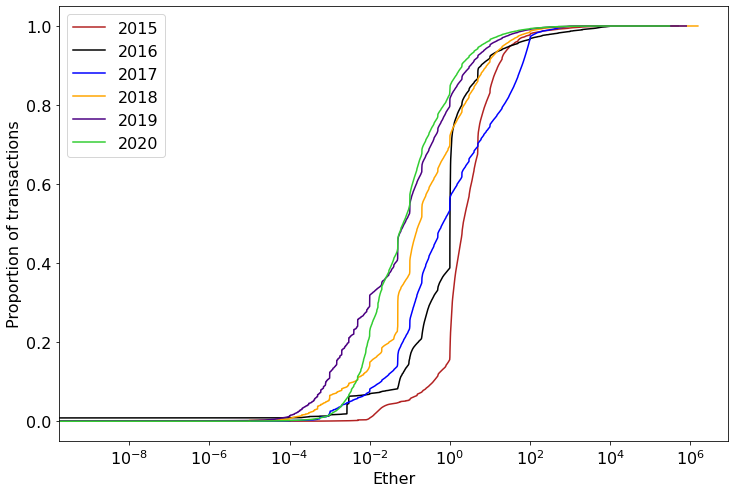

In [ ]:
# get value field of each year 
val = pd.to_numeric(df['value'])
x1 = np.sort(val_df)
y1 = np.arange(len(val)) / float(len(val)) 

# plot cdf of each year
plt.figure(figsize=(12, 8)) 
plt.rcParams['font.size'] = '16'
plt.xscale("log")
plt.plot(x1, y1, color="firebrick", label="2015") 
plt.plot(x2, y2, color="black", label="2016") 
plt.plot(x3, y3, color="blue", label="2017") 
plt.plot(x4, y4, color="orange", label="2018")  
plt.plot(x5, y5, color="indigo", label="2019")  
plt.plot(x6, y6, color="limegreen", label="2020")
plt.xlabel('Ether')
plt.ylabel('Proportion of transactions')
plt.legend() 

plt.savefig('txplot_all.png')

# Node importance (Page Rank, HITS)

In [ ]:
# HITS algorithm
hits_results = nx.hits(G1)
hub = hits_results[0]
auth = hits_results[1]

# get top 10 nodes by hub and auth score
top_hub = sorted(hub.items(), key=operator.itemgetter(1), reverse=True)[0:10]
top_auth = sorted(auth.items(), key=operator.itemgetter(1), reverse=True)[0:10]
print(top_hub)
print(top_auth)

In [ ]:
# weighted page rank using DiGraph
pr = nx.pagerank(G1,weight='value')

# get top 10 nodes by PR score
top_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)[0:10]
print(top_pr)

# Degree distribution

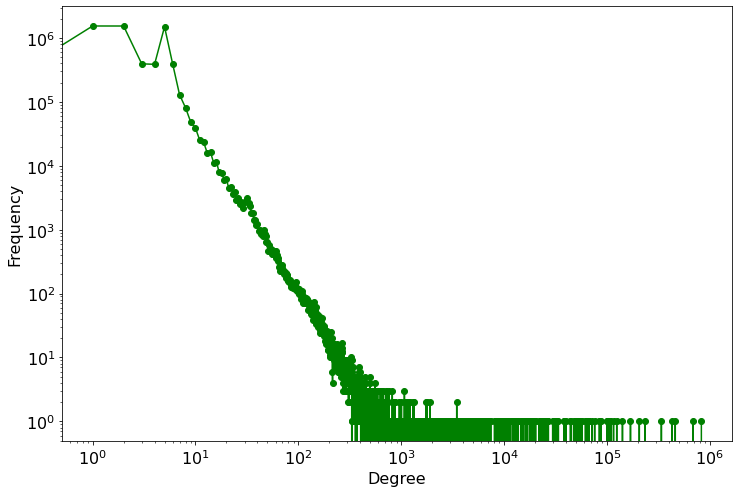

In [ ]:
# plot degree distribution
# repeat for all years
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))

plt.figure(figsize=(12, 8)) 
plt.rcParams['font.size'] = '16'
plt.loglog(range(len(degree_freq)), degree_freq, 'go-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.savefig('degree_dist_2017.png')

In [ ]:
# plot probability density function (pdf) to determine fit with powerlaw model
# repeat for all years
degree_sequence = sorted([d for n, d in degrees], reverse=True)
fit = pwl.Fit(degree_sequence)

# plot pdf
plt.figure() 
pdf_plot = fit.plot_pdf(color='g', linewidth=1)
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=pdf_plot, linewidth=2)

# get powerlaw model coefficient, minimum x value and sigma value
print(fit.alpha)
print(fit.xmin)
print(fit.power_law.sigma)
plt.savefig('pdf_2017.png')

# Other graph metrics

In [ ]:
# clustering, assortativity coef 
clustering_dict = nx.clustering(G1)
clustering_coef = sum(clustering_dict.values())
assortativity_coef = nx.degree_assortativity_coefficient(G1)
print(clustering_coef, assortativity_coef)

In [ ]:
# SCC and WCC stats
wcc = nx.weakly_connected_components(G)
wcc_largest = sorted(nx.weakly_connected_components(G))[0]
print('#WCC: %d, size of largest WCC: %d'%(len(list(wcc)),len(wcc_largest)))

scc = nx.strongly_connected_components(G1)
scc_largest = sorted(nx.strongly_connected_components(G))[0]
print('#SCC: %d, size of largest SCC: %d'%(len(list(scc)),len(scc_largest)))